<a href="https://colab.research.google.com/github/matvb/Sudoku-Genetico/blob/main/Tarefa_5_Algoritmo_Gen%C3%A9tico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inteligência Artifical
## Tarefa 5 - Algoritmo Genético
### Mateus de Almeida Villas Boas
### DRE: 115054675



## Imports

In [30]:
import numpy as np
import random
import math

## Implementação do Algoritmo Genético


### Preenchendo a matriz real do problema (9x9)


Esta é a matriz do problema o qual é preciso achar a solução.
<br>
<br>
Como ela é uma matriz específica, com tamanho e preenchimento inicial definidos, decidi fazer a instanciação inicial dela de maneira hard-coded.
<br>
<br>
tam_tabuleiro -> Decide o tamanho dos lados da matriz
np.zeros((tam_tabuleiro,tam_tabuleiro)) -> Cria a matriz de zeros quadrada de lado tam_tabuleiro
<br>
<br>
Depois da função preenche_fixos, todos os campos "vazios" estarão preenchidos com zero, sinalizando para as próximas funções onde poderão ser alocados os números variáveis. E os já preenchidos nessa função serão fixos até o término do programa.



<div>
<img src="https://drive.google.com/thumbnail?id=1yezhTg1ErTEjZgBPnpy4E5nGTg39xt9i&authuser=0&sz=w1423-h789" width="300"/>
</div>



In [31]:
tam_tabuleiro = 9
tabuleiro = np.zeros((tam_tabuleiro,tam_tabuleiro))
tabuleiro_original = np.copy(tabuleiro)

def preenche_fixos(tab):
  tab[0][3] = 7
  tab[1][0] = 1
  tab[2][3] = 4
  tab[2][4] = 3
  tab[2][6] = 2
  tab[3][8] = 6
  tab[4][3] = 5
  tab[4][5] = 9
  tab[5][6] = 4
  tab[5][7] = 1
  tab[5][8] = 8
  tab[6][4] = 8
  tab[6][5] = 1
  tab[7][3] = 2
  tab[7][7] = 5
  tab[8][1] = 4
  tab[8][6] = 3

  num_variaveis = (tab == 0).sum()

  return tab, num_variaveis

### Preenchendo uma matriz teste (4X4)




Esta é uma matriz teste consideravelmente mais fácil de se trabalhar e achar a solução do que a matriz real do problema
<br>
<br>
Toda a função de preenchimento é igual exceto pelos valores fixos e pelo valor de tam_tabuleiro


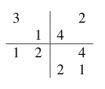

Matriz exemplo tirada do exercício 1 da lista de exercícios da semana 6


In [20]:
tam_tabuleiro = 4
tabuleiro = np.zeros((tam_tabuleiro,tam_tabuleiro))
tabuleiro_original = np.copy(tabuleiro)

def preenche_fixos(tab):
  tab[0][0] = 3
  tab[1][1] = 1
  tab[2][0] = 1
  tab[2][1] = 2
  tab[1][2] = 4
  tab[0][3] = 2
  tab[2][3] = 4
  tab[3][2] = 2
  tab[3][3] = 1

  num_variaveis = (tab == 0).sum()

  return tab, num_variaveis

### Criando tabuleiro campos iniciais com números escolhidos aleatoriamente no intervalo de números possíveis (de 1 até tam_tabuleiro)



<br>
Todos os campos considerados vazios (campos com valor 0), são preenchidos agora por um numero aleatório dentre os possíveis de acordo com o tamanho do Sudoku (entre 1 e tam_tabuleiro).
<br>
<br>
Todas as coordenadas preenchidas nesse processo são guardadas na lista "variáveis", pois serão elas as variáveis da função.
<br>
<br>
Somente os campos correspondentes as coordenadas gravadas nessa lista poderão ser mudadas no processo de Hill Climbing, fazendo com os números que foram preenchidos anteriormente permanecam fixos.

In [32]:
def preenche_iniciais(tab):
  variaveis_coord = []
  variaveis = []
  for i,row in enumerate(tab):
    for j,value in enumerate(row):
      if value == 0:
        num_rand = random.randint(1, tam_tabuleiro)
        tab[i][j] = num_rand
        variaveis_coord.append((i,j))
        variaveis.append(num_rand)

  return tab, variaveis

### Contrução da população inicial
N = Número de individuos da população
<br>
Retorno: Um conjunto de N indivíduos gerados aleatoriamente que correspondem a configurações do tabuleiro.

In [33]:
def pop_inicial(N, num_variaveis):
  pop_init = []
  
  for i in range(N):
    aux = []
    for j in range(num_variaveis):
      num_rand = random.randint(1, tam_tabuleiro)
      aux.append(num_rand)
    pop_init.append(aux)

  return pop_init



### Função objetivo

<br>
O valor retornado pela função objetivo é o número de casas erradas no tabuleiro. É uma função de minimização visto que o objetivo final é ter um tabuleiro em que a quantidade de casas erradas seja 0.
<br>
<br>
A função acha esse número percorrendo o tabuleiro e cada vez que um número se repete em uma mesma linha, coluna ou bloco é somado 1.
<br>
<br>
Se uma linha tiver três casas com o número 5 e duas casas com o número 7. A função somará 3 ao total. Porque existem dois número 5 errados e um número 7 errado nesta fileira.
<br>
<br>
Faz-se a mesma coisa para todas as fileiras, colunas e blocos e tem-se o valor total da função que é retornado.



In [34]:
def interpreta_como_tabuleiro(tab_orig, list_variaveis_orig):
  tab = np.copy(tab_orig)
  list_variaveis = list_variaveis_orig.copy()
  for i,row in enumerate(tab):
    for j,value in enumerate(row):
      if value == 0:
        tab[i][j] = list_variaveis[0]
        list_variaveis.pop(0)

  return tab

def objetivo(tab_orig, list_variaveis):
  tab = interpreta_como_tabuleiro(tab_orig, list_variaveis)

  soma_col = 0
  soma_row = 0
  soma_bloco = 0
  ja_computados =[]

  # Calcula o somatório da diferença da soma de cada linha e coluna em relação a soma certa.
  for i, row in enumerate(tab):
    aux_row = 0
    aux_col = 0
    aux_row2 = []
    aux_col2 = []

    for j, value in enumerate(row):
      if (value in aux_row2) and ((i,j) not in ja_computados):
        ja_computados.append((i,j))
        aux_row += 1
      aux_row2.append(value)
      if (tab[j][i] in aux_col2) and ((i,j) not in ja_computados):
        ja_computados.append((j,i))
        aux_col += 1
      aux_col2.append(tab[j][i])

    soma_row += aux_row
    soma_col += aux_col

  # Calcula o somatório da diferença da soma de cada bloco interno em relação a soma certa.
  tam_bloco = int(math.sqrt(tam_tabuleiro))
  quant_blocos = (tam_tabuleiro**2)/(tam_bloco**2)
  for bloco1 in range(tam_bloco):
    for bloco2 in range(tam_bloco):
      aux_bloco = 0
      aux_bloco2 = []
      for i in range(tam_bloco):
        for j in range(tam_bloco):
          if (tab[i+(tam_bloco*bloco1)][j+(tam_bloco*bloco2)] in aux_bloco2) and ((i,j) not in ja_computados):
            ja_computados.append((j,i))
            aux_bloco += 1
          aux_bloco2.append(tab[i+(tam_bloco*bloco1)][j+(tam_bloco*bloco2)])

      soma_bloco += aux_bloco

  # Soma os calculos anterios para linhas, colunas e blocos para ter o valor da função para o tabuleiro todo.
  
  soma_total = soma_row + soma_col + soma_bloco
  soma_total_invert = (tam_tabuleiro*tam_tabuleiro) - soma_total
  return soma_total_invert

### Função Roleta


In [35]:
def calc_roleta(valores_objetivo):
  roleta = []
  for index, i  in enumerate(valores_objetivo):
    if index == 0:
      roleta.append(i)
    else:
      roleta.append(roleta[-1]+i)

  return roleta

#### População intermediária

In [44]:
def pop_intermediaria(pop_init, verbose=False):
  pop_intermed = []

  valores_objetivo = []
  for i in pop_init:
    valores_objetivo.append(objetivo(tabuleiro, i))

  roleta = calc_roleta(valores_objetivo)
  

  valores_sorteados = []
  for i in range(len(pop_init)):
    sorteio = random.uniform(0,roleta[-1])
    valores_sorteados.append(sorteio)

  if verbose:
    print("Roleta: \n", roleta, "\n")
    print("Valores Sorteados: \n", valores_sorteados, "\n")

  for index_i, valor_sorteado in enumerate(valores_sorteados):
    for index_j, j in enumerate(roleta):
      if valor_sorteado <= j:
        pop_intermed.append(pop_init[index_j])
        break

  return pop_intermed

### CrossOver

In [37]:
def crossover(elemento1, elemento2, quant_cortes):
  tam_elemento = len(elemento1)
  novo1 = []
  novo2 = []

  cortes = []
  for i in range(quant_cortes):
    corte = random.randint(1,tam_elemento-1)
    while corte in cortes:
      corte = random.randint(1,tam_elemento-1)
    cortes.append(corte)

  cortes.sort()
  cortes.append('fim')


  #print("cortes", cortes)
  for index_i, i in enumerate(cortes):
    for j in range(tam_elemento):  
      if i != "fim":    
        if (j < i):
          if (j+1 > len(novo1)):
            if (index_i % 2) == 0:
              novo1.append(elemento1[j])
              novo2.append(elemento2[j])
            else:
              novo1.append(elemento2[j])
              novo2.append(elemento1[j])
        else:
          break

      else:
        if (j+1 > len(novo1)):
          if (index_i % 2) == 0:
            novo1.append(elemento1[j])
            novo2.append(elemento2[j])
          else:
            novo1.append(elemento2[j])
            novo2.append(elemento1[j])

  
  return novo1, novo2



### Mutação

In [38]:
def mutacao(individuo, quant_genes):
  novo_individuo = list(individuo)
  index_genes_mutados = []
  for i in range(quant_genes):
    index = random.randint(0,len(individuo)-1)
    while index in index_genes_mutados:
      index = random.randint(0,len(individuo)-1)

    index_genes_mutados.append(index)

  #print("Genes mutados:", index_genes_mutados)

  for i in index_genes_mutados:
    aux = individuo[i]
    novo_valor = random.randint(1,tam_tabuleiro)
    while novo_valor == aux:
      novo_valor = random.randint(1,tam_tabuleiro)
    
    novo_individuo[i] = novo_valor


  return novo_individuo
    


### Função Principal

In [ ]:
# Parâmetros para colorir e formatar o print dos textos
CBOLD     = '\33[1m'
CRED = '\033[91m'
CGREEN  = '\33[92m'
CBLUE   = '\33[34m'
CEND = '\033[0m'

def parametros_fixos(letra):
  if letra == 'a':
    N = 100
    prob_crossover = 0.80
    pts_crossover = 1
    prob_mutacao = 0.03
    genes_mutados = 3
    num_geracoes = 100
  elif letra == 'b':
    N = 100
    prob_crossover = 0.80
    pts_crossover = 3
    prob_mutacao = 0.03
    genes_mutados = 3
    num_geracoes = 100
  elif letra == 'c':
    N = 100
    prob_crossover = 0.80
    pts_crossover = 3
    prob_mutacao = 0.15
    genes_mutados = 3
    num_geracoes = 100

  return N, prob_crossover, pts_crossover, prob_mutacao, genes_mutados, num_geracoes

def main(N, prob_crossover, pts_crossover, prob_mutacao, genes_mutados, num_geracoes, verbose=False):
  
  # Instancia o tabuleiro inicial apenas com os valores fixos preenchidos e determina a quantidade de variaveis possiveis
  global tabuleiro
  tabuleiro, num_variaveis = preenche_fixos(tabuleiro)

  print(CBOLD,CBLUE,"NOVA EXECUÇÃO", CEND, "\n")

  if verbose:
    print("Tabuleiro inicial: \n",tabuleiro, "\n")
    print("Número de variáveis:",num_variaveis, "\n")

  # Define o numero N de elementos que uma população inicial deve ter e a cria
  pop_init = pop_inicial(N, num_variaveis)
  print(CBOLD,CGREEN,"População inicial: \n", CEND , pop_init, "\n")

  i = 0

  pop_testada = pop_init
  for i in range(num_geracoes):

    pop_intermed = pop_intermediaria(pop_testada, verbose)

    pop_aux = list(pop_intermed)
    pop_crossover = []
    while len(pop_aux) != 0:
      element1_cross = random.choice(pop_aux)
      pop_aux.remove(element1_cross)
      element2_cross = random.choice(pop_aux)
      pop_aux.remove(element2_cross)

      # Testa chance e faz o CrossOver se passar
      if random.random() <= prob_crossover:
        element1_novo, element2_novo = crossover(element1_cross, element2_cross, pts_crossover)
      else:
        element1_novo = element1_cross
        element2_novo = element2_cross

      pop_crossover.append(element1_novo)
      pop_crossover.append(element2_novo)
    

    

    pop_mutacao = []

    for elemento in pop_crossover:
      if random.random() <= prob_mutacao:
        #print(CBOLD,CGREEN,"FAZENDO MUTAÇÂO",CEND, "\n")
        element_novo = mutacao(elemento,genes_mutados)
      else:
        #print(CBOLD,CRED,"NÂO FAZENDO MUTAÇÂO",CEND, "\n")
        element_novo = elemento
      
      pop_mutacao.append(elemento)

    if verbose:
      print(CBOLD,CBLUE,"Geração:", i+1,CEND, "\n")
      print("População intermediária: \n", pop_intermed, "\n")
      print("População depois do CrossOver: \n", pop_crossover, "\n")
      print("População depois da Mutação: \n", pop_mutacao, "\n")

    i += 1

    pop_testada = pop_mutacao

  print(CBOLD,CRED,"População final: \n", CEND , pop_testada, "\n")

  # Printar os tabuleiros finais
  valor_media_final = 0
  melhor_valor_final = 0
  if verbose: 
    print(CBOLD,CGREEN,"Tabuleiros da Poupulação final dessa geração: \n", CEND)
  for elemento in pop_testada:
    tab = interpreta_como_tabuleiro(tabuleiro, elemento)
    valor_tab = objetivo(tabuleiro, elemento)
    if verbose:
      print(tab," Valor: ", valor_tab, "\n")

    valor_media_final += valor_tab
    if valor_tab > melhor_valor_final:
      melhor_valor_final = valor_tab

  valor_media_final  = valor_media_final/N


  valor_media_init = 0
  melhor_valor_init = 0
  for elemento in pop_init:
    valor_tab = objetivo(tabuleiro, elemento)
    valor_media_init += valor_tab
    if valor_tab > melhor_valor_init:
      melhor_valor_init = valor_tab

  valor_media_init  = valor_media_init/N
    
  return valor_media_init, melhor_valor_init, valor_media_final, melhor_valor_final

# Probabilidades e valores fixos
N, prob_crossover, pts_crossover, prob_mutacao, genes_mutados, num_geracoes = parametros_fixos("a")

list_med_init = []
list_melhor_init = []
list_med_final = []
list_melhor_final = []

for repeticao in range(10):
  valor_media_init, melhor_valor_init, valor_media_final, melhor_valor_final = main(N, prob_crossover, pts_crossover, prob_mutacao, genes_mutados, num_geracoes)
  list_med_init.append(valor_media_init)
  list_melhor_init.append(melhor_valor_init)
  list_med_final.append(valor_media_final)
  list_melhor_final.append(melhor_valor_final)

for repeticao in range(10):
  print(CBOLD,CGREEN,"Execução:", repeticao+1, "\n", CEND)
  print(CBOLD,"Média da população inicial:", list_med_init[repeticao], "\n",CEND)
  print(CBOLD,"Melhor da população inicial:", list_melhor_init[repeticao], "\n",CEND)
  print(CBOLD,"Média da população final:", list_med_final[repeticao], "\n",CEND)
  print(CBOLD,"Melhor da população final:", list_melhor_final[repeticao], "\n",CEND)


## Execução e Prints

In [ ]:
# Instancia o tabuleiro inicial apenas com os valores fixos preenchidos e determina a quantidade de variaveis possiveis
tabuleiro, num_variaveis = preenche_fixos(tabuleiro)
print("Tabuleiro inicial: \n",tabuleiro, "\n")
print("Número de variáveis:",num_variaveis, "\n")

# Define o numero N de elementos que uma população inicial deve ter e a cria
N = 4
pop_init = pop_inicial(N, num_variaveis)
print("População inicial: \n", pop_init, "\n")

pop_intermed = pop_intermediaria(pop_init)
print("População intermediária: \n", pop_intermed, "\n")


crossover([3, 4, 1, 2, 1, 4, 1], [4, 4, 4, 3, 3, 1, 4],3)


mutacao([3, 4, 1, 2, 1, 4, 1],2)

Tabuleiro inicial: 
 [[0. 0. 0. 7. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 4. 3. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 6.]
 [0. 0. 0. 5. 0. 9. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 4. 1. 8.]
 [0. 0. 0. 0. 8. 1. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 5. 0.]
 [0. 4. 0. 0. 0. 0. 3. 0. 0.]] 

Número de variáveis: 64 

População inicial: 
 [[6, 4, 9, 4, 1, 8, 5, 1, 3, 6, 4, 9, 6, 5, 6, 9, 8, 6, 4, 5, 2, 4, 2, 7, 6, 8, 1, 7, 7, 5, 1, 1, 1, 7, 5, 8, 6, 3, 4, 9, 1, 2, 2, 6, 4, 8, 2, 8, 3, 1, 7, 5, 1, 2, 9, 3, 8, 8, 1, 6, 8, 7, 8, 3], [1, 3, 1, 8, 8, 1, 1, 9, 4, 2, 2, 4, 2, 2, 4, 6, 4, 8, 7, 5, 2, 2, 7, 3, 2, 1, 9, 9, 1, 6, 6, 1, 9, 3, 5, 9, 1, 6, 4, 4, 4, 1, 2, 3, 4, 6, 1, 9, 6, 4, 9, 9, 3, 7, 2, 6, 5, 2, 8, 7, 5, 3, 7, 9], [3, 5, 6, 8, 7, 6, 3, 6, 4, 7, 1, 9, 5, 2, 4, 5, 2, 3, 7, 2, 4, 8, 4, 8, 7, 9, 8, 3, 6, 9, 9, 5, 5, 9, 6, 9, 6, 2, 6, 4, 2, 7, 4, 9, 2, 4, 2, 2, 9, 5, 2, 8, 1, 6, 2, 8, 6, 8, 4, 6, 7, 5, 4, 5], [5, 9, 7, 8, 4, 6, 3, 6, 3, 9, 8, 2, 4, 4, 9, 6, 6, 7, 2, 9, 5, 7, 7, 3, 1, 

[4, 4, 1, 2, 4, 4, 1]

## Relatório

### Verbose = False:
Matriz 9X9, sem elitismo, letra 'a' - 38 segundos

### Verbose = True:
Matriz 9X9, sem elitismo, letra 'a' - 52 segundos

### Error
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)






###Analise resultados:
####sem elitismo, letra 'a'

Execução: 1 
<br>
Média da população inicial: 30.47 
<br>
Melhor da população inicial: 43 
<br>
Média da população final: 47.59 
<br>
Melhor da população final: 51 

Execução: 2 
<br>
Média da população inicial: 29.33 
<br>
Melhor da população inicial: 38 
<br>
Média da população final: 46.23 
<br>
Melhor da população final: 51 

Execução: 3 
<br>
Média da população inicial: 29.51 
<br>
Melhor da população inicial: 38 
<br>
Média da população final: 40.73 
<br>
Melhor da população final: 48 

Execução: 4 
<br>
Média da população inicial: 29.45 
<br>
Melhor da população inicial: 38 
<br>
Média da população final: 46.07 
<br>
Melhor da população final: 50 

Execução: 5 
<br>
Média da população inicial: 29.85 
<br>
Melhor da população inicial: 40 
<br>
Média da população final: 43.46 
<br>
Melhor da população final: 49 

Execução: 6 
<br>
Média da população inicial: 29.87 
<br>
Melhor da população inicial: 40 
<br>
Média da população final: 39.02 
<br>
Melhor da população final: 45 

Execução: 7 
<br>
Média da população inicial: 30.06 
<br>
Melhor da população inicial: 39 
<br>
Média da população final: 41.83 
<br>
Melhor da população final: 46 

Execução: 8 
<br>
Média da população inicial: 29.95 
<br>
Melhor da população inicial: 38 
<br>
Média da população final: 42.82 
<br>
Melhor da população final: 47 

Execução: 9 
<br>
Média da população inicial: 29.53 
<br>
Melhor da população inicial: 38 
<br>
Média da população final: 40.66 
<br>
Melhor da população final: 45 

Execução: 10 
<br>
Média da população inicial: 29.23 
<br>
Melhor da população inicial: 37 
<br>
Média da população final: 38.13 
<br>
Melhor da população final: 43 